# Word Cloud

## 1.Collect Tweets into MongoDB 

### Install Python libraries
You may need to restart your Jupyter Notebook instance after installed those libraries.

In [1]:
!pip install pymongo

In [2]:
!pip install pymongo[srv]

In [3]:
!pip install dnspython

In [4]:
!pip install tweepy

In [5]:
!pip install twitter

In [6]:
pip install certifi

Note: you may need to restart the kernel to use updated packages.


### Import Python libraries

In [7]:
import pymongo
from pymongo import MongoClient
import json
import tweepy
import twitter
from pprint import pprint
import configparser
import pandas as pd
import certifi

### Load the Authorization Info
Save database connection info and API Keys in a config.ini file and use the configparse to load the authorization info.

In [8]:
config = configparser.ConfigParser()
config.read('config.ini')

CONSUMER_KEY      = config['mytwitter']['api_key']
CONSUMER_SECRET   = config['mytwitter']['api_secrete']
OAUTH_TOKEN       = config['mytwitter']['access_token']
OATH_TOKEN_SECRET = config['mytwitter']['access_secrete']

mongod_connect = config['mymongo']['connection']

### Connect to the MongoDB Cluster
the name database and collection is here.

In [9]:
ca = certifi.where()                                 # Fix SSR error

client = MongoClient(mongod_connect , tlsCAFile=ca)  # connect to mongo and fix SSL problem with tlsCAFile=ca
db = client.Twitter                                  # use or create a database named Twitter
tweet_collection = db.new_tweet_collection           # use or create a collection named tweet_collection

### Authorize the Stream API

In [10]:
stream_auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
stream_auth.set_access_token(OAUTH_TOKEN, OATH_TOKEN_SECRET)

strem_api = tweepy.API(stream_auth)

### Use the REST API to Collect Tweets
Authorize the REST API

In [11]:
rest_auth = twitter.oauth.OAuth(OAUTH_TOKEN,OATH_TOKEN_SECRET,CONSUMER_KEY,CONSUMER_SECRET)
rest_api = twitter.Twitter(auth=rest_auth)

Define the query for the REST API

In [12]:
count = 10                                   # number of returned tweets
q = "#ผู้ว่ากทม"                                # define the keywords, tweets contain election
geocode = "38.4392897,-78.9412224,50mi"      # defin the location, in Harrisonburg, VA

Search and Collect data

In [13]:
start = tweet_collection.count_documents({}) # จำนวนคอลเลกชั่นที่มีในปัจจุบัน
since_id_old = start
since_id_new = start+count
i=1

while(since_id_new != since_id_old):
    search_results = rest_api.search.tweets( count=count,q=q) #you can use both q and geocode
    statuses = search_results["statuses"]

    for statuse in statuses:
        try:# time sleep to slow request
            if tweet_collection.count_documents({})%100==0:
                time.sleep(5)
                
            # fetching the status
            tweet = strem_api.get_status(statuse['id_str'], tweet_mode = "extended")
            
            # fetching the text attribute
            full_text  = tweet.full_text

            # collection stucture
            new_tweet = {
                'id_doc': since_id_old,
                'id_str': statuse['id_str'],
                'keyword': q,
                'full_text': full_text,
            }
            
            # make sure the collected tweets are unique
            abc = tweet_collection.find_one({'id_str': statuse['id_str']})
            if abc==None:
                # insert tweet
                tweet_collection.insert_one(new_tweet)
                print("The text of the status is \n:" + full_text )
                print(i, "documents insert\n\n")
                i=i+1
                since_id_old=since_id_old+1
            else:
                print("same data in collection")       
            
        except:
            pass

The text of the status is 
:RT @madiussacretus: สิ่งที่หลายคนอาจจะไม่รู้ว่ารถเมล์จากสนามบินดอนเมืองเข้าตัวเมือง ทางเชื่อม Airport Link , MRT ตรงมักกะสัน 

เป็นผลงานของ…
1 documents insert


The text of the status is 
:RT @BSunny1999: ของแทงว่า ชัชชาติจะชนะ ผู้ว่า กทม. แล้วฝั่งตู่ก็จะยัดข้อหาอะไรสักอย่างให้หมดสิทธิแล้วก็ปลด หลังจากนั้นด้วยความแข็งแกร่งของ…
2 documents insert


The text of the status is 
:RT @GUN_NTN: ใช่ค่ะ ตอนนี้2021แล้ว ที่จริงปี2020 ไทยควรมีรถไฟความเร็วสูงเชื่อมทุกภาคแล้ว และใช่ค่ะผลงานการผลักดันของชัชชาติ และใช่ค่ะพวกถ่ว…
3 documents insert


The text of the status is 
:RT @GUN_NTN: ใช่ค่ะ ตอนนี้2021แล้ว ที่จริงปี2020 ไทยควรมีรถไฟความเร็วสูงเชื่อมทุกภาคแล้ว และใช่ค่ะผลงานการผลักดันของชัชชาติ และใช่ค่ะพวกถ่ว…
4 documents insert


The text of the status is 
:RT @orbitta: คนกรุงเทพกำลังเจอสภาพเดียวกับเด็กลาดกระบัง #ผู้ว่ากทม https://t.co/DvTvLo3XV0
5 documents insert


The text of the status is 
:RT @GUN_NTN: ใช่ค่ะ ตอนนี้2021แล้ว ที่จริงปี2020 ไทยควรมีรถไฟความเร็วสูงเ

In [14]:
list(tweet_collection.find())

[{'_id': ObjectId('61b8ce27285b6c24d36f414e'),
  'id_doc': 0,
  'id_str': '1470801380335968261',
  'keyword': '#ผู้ว่ากทม',
  'full_text': 'RT @caddyAe: 5555555555555555555555555555555555555555555555555555555555 กาวสัส #ผู้ว่ากทม https://t.co/wMAgBhw7W6'},
 {'_id': ObjectId('61b8ce27285b6c24d36f414f'),
  'id_doc': 1,
  'id_str': '1470801373809631232',
  'keyword': '#ผู้ว่ากทม',
  'full_text': 'RT @lamalila_m: เห็นชัชชาติลงสมัคร #ผู้ว่ากทม นี่บอกเลยว่าปักธงขอเลือก ชื่นชมตั้งแต่เป็นรมวคมนาคม ผลงานรถเมล์ A1-3 เคยฟังแกเล่าว่าตอนนั้นสน…'},
 {'_id': ObjectId('61b8ce28285b6c24d36f4150'),
  'id_doc': 2,
  'id_str': '1470801373696442371',
  'keyword': '#ผู้ว่ากทม',
  'full_text': 'RT @caddyAe: 5555555555555555555555555555555555555555555555555555555555 กาวสัส #ผู้ว่ากทม https://t.co/wMAgBhw7W6'},
 {'_id': ObjectId('61b8ce29285b6c24d36f4151'),
  'id_doc': 3,
  'id_str': '1470801368134795268',
  'keyword': '#ผู้ว่ากทม',
  'full_text': 'RT @_Akina__: ติดป้ายหาเสียงแบบมีวิสัยทัศน์มาก😒 กุจะเลือกดีมั้

In [15]:
tweet_json = list(tweet_collection.find())

In [16]:
tweet_json[0]['full_text']

'RT @caddyAe: 5555555555555555555555555555555555555555555555555555555555 กาวสัส #ผู้ว่ากทม https://t.co/wMAgBhw7W6'

### cut word

In [17]:
def cutword(wordinput):
    wordmodify = wordinput+"`"

    #ตัดชื่อคน รีทวิต
    Tweet = wordmodify.find("RT") 
    endnameTweet = wordmodify.find(":")
    substring = wordmodify[Tweet:endnameTweet+1]
    # print(substring)

    cutTweet=wordmodify.replace(substring,"")
    # print(cutTweet)

    #ตัดหลัง https
    https = cutTweet.find("https://t.co") 
    endpoint = cutTweet.find("`")
    substring = cutTweet[https:endpoint+1]
    # print(substring)

    aa=cutTweet.replace(substring,"")
    # print(aa)
    return aa

In [18]:
cutword(tweet_json[0]['full_text'])

' 5555555555555555555555555555555555555555555555555555555555 กาวสัส #ผู้ว่ากทม '

In [19]:
all_tweet = ""

for i in range(tweet_collection.count_documents({})):
  all_tweet += cutword(tweet_json[i]['full_text'])+"\n"

print(all_tweet)

 5555555555555555555555555555555555555555555555555555555555 กาวสัส #ผู้ว่ากทม 
 เห็นชัชชาติลงสมัคร #ผู้ว่ากทม นี่บอกเลยว่าปักธงขอเลือก ชื่นชมตั้งแต่เป็นรมวคมนาคม ผลงานรถเมล์ A1-3 เคยฟังแกเล่าว่าตอนนั้นสน…
 5555555555555555555555555555555555555555555555555555555555 กาวสัส #ผู้ว่ากทม 
 ติดป้ายหาเสียงแบบมีวิสัยทัศน์มาก😒 กุจะเลือกดีมั้ยว่ะ???  #ผู้ว่ากทม 
 สรุปเขาด่าใครหรอครับพี่ตา นกงงไปหมด

#ผู้ว่ากทม 
 สิ่งนึงที่เรารู้สึกว่าฟังจาก speech ของ #พี่เอ้ แล้วชวนขนลุกปนจุดตกคือ การเอา sop ในยุคตัวเองมาบลัพคนรุ่นใหม่ ว่าการสมัครเ…
 ถ้าคนกรุงเทพยังเลือกประชาธิปัตย์เป็นผู้ว่า ก็อย่าได้กล้าด่าคนต่างจังหวัดว่าโง่

#ผู้ว่ากทม
 ของแทงว่า ชัชชาติจะชนะ ผู้ว่า กทม. แล้วฝั่งตู่ก็จะยัดข้อหาอะไรสักอย่างให้หมดสิทธิแล้วก็ปลด หลังจากนั้นด้วยความแข็งแกร่งของ…
 ทายาทสายตรงไอน์สไตน์ จบ MIT ชมตัวเองออกสื่อ บอกว่าเตรียมตัวเป็นผู้ว่ามา 30 ปี งั้นก็ตั้งแต่ตัวเองอายุ 19?? ตอแหลฉิบหาย พรรค…
 พี่เอ้จะเปลี่ยนกรุงเทพ ไม่รู้หรือว่าสายไฟนั่นน่ะ เสี่ยงที่จะขาดลงมาได้หากลมพัดแผ่นไวนีลของพี่หล่นลงมาโดนคนเค้าได้ครับ
จะเป…
 สิ

### drop collection

In [20]:
tweet_collection.drop()

# 2.Word Cloud ภาษาไทย

In [21]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


In [22]:
conda install -c conda-forge wordcloud

Solving environment: ...working... done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [23]:
pip install pythainlp

Note: you may need to restart the kernel to use updated packages.


In [24]:
import pythainlp
from pythainlp import word_tokenize
from pythainlp.corpus import get_corpus # for getting stopwords

import wordcloud
from wordcloud import WordCloud

import matplotlib.pyplot as plt
import numpy as np
import re

%matplotlib inline
%config InlineBackend.figure_format='retina'

## แบ่งคำแล้วแยกแต่ละคำด้วยช่องว่าง

In [25]:
words = word_tokenize(all_tweet)
print(words)

[' ', '5555555555555555555555555555555555555555555555555555555555', ' ', 'กาว', 'สัส', ' ', '#', 'ผู้ว่า', 'กทม', ' ', '\n', ' ', 'เห็น', 'ชัชชาติ', 'ลงสมัคร', ' ', '#', 'ผู้ว่า', 'กทม', ' ', 'นี่', 'บอก', 'เลย', 'ว่า', 'ปัก', 'ธง', 'ขอ', 'เลือก', ' ', 'ชื่นชม', 'ตั้งแต่', 'เป็น', 'รมว', 'คมนาคม', ' ', 'ผลงาน', 'รถเมล์', ' ', 'A', '1', '-', '3', ' ', 'เคย', 'ฟัง', 'แก', 'เล่า', 'ว่า', 'ตอนนั้น', 'สน', '…', '\n', ' ', '5555555555555555555555555555555555555555555555555555555555', ' ', 'กาว', 'สัส', ' ', '#', 'ผู้ว่า', 'กทม', ' ', '\n', ' ', 'ติด', 'ป้ายหาเสียง', 'แบบ', 'มี', 'วิสัยทัศน์', 'มาก', '😒', ' ', 'กุ', 'จะ', 'เลือก', 'ดี', 'มั้ย', 'ว่ะ', '???', '  ', '#', 'ผู้ว่า', 'กทม', ' ', '\n', ' ', 'สรุป', 'เขา', 'ด่า', 'ใคร', 'หรอ', 'ครับ', 'พี่', 'ตา', ' ', 'นก', 'งง', 'ไป', 'หมด', '\n', '\n', '#', 'ผู้ว่า', 'กทม', ' ', '\n', ' ', 'สิ่ง', 'นึง', 'ที่', 'เรา', 'รู้สึก', 'ว่า', 'ฟัง', 'จาก', ' ', 'speech', ' ', 'ของ', ' ', '#', 'พี่', 'เอ้', ' ', 'แล้ว', 'ชวน', 'ขนลุก', 'ปน', 'จุด', 'ตก', 

In [29]:
all_words = ' '.join(words).lower().strip()
# all_word = re.sub('(\n|\s{2})', '', all_words)
all_words[:500]

'5555555555555555555555555555555555555555555555555555555555   กาว สัส   # ผู้ว่า กทม   \n   เห็น ชัชชาติ ลงสมัคร   # ผู้ว่า กทม   นี่ บอก เลย ว่า ปัก ธง ขอ เลือก   ชื่นชม ตั้งแต่ เป็น รมว คมนาคม   ผลงาน รถเมล์   a 1 - 3   เคย ฟัง แก เล่า ว่า ตอนนั้น สน … \n   5555555555555555555555555555555555555555555555555555555555   กาว สัส   # ผู้ว่า กทม   \n   ติด ป้ายหาเสียง แบบ มี วิสัยทัศน์ มาก 😒   กุ จะ เลือก ดี มั้ย ว่ะ ???    # ผู้ว่า กทม   \n   สรุป เขา ด่า ใคร หรอ ครับ พี่ ตา   นก งง ไป หมด \n \n # ผู้ว่า '

### \n
ตัด \n ออก

In [ ]:
# re.sub('(\n|\s{2})', '', all_words)

### stop word 
คำคือที่เราไม่ต้องการเอา

In [32]:
stopwords = {'\n','ว่า','ของ','แล้ว'} # set
print(type(stopwords))
print(stopwords)

<class 'set'>
{'ว่า', 'ของ', 'แล้ว', '\n'}


## Word cloud
* colormap: https://matplotlib.org/3.3.3/tutorials/colors/colormaps.html
* color name: https://matplotlib.org/3.1.0/gallery/color/named_colors.html
* sample mask images: https://github.com/prasertcbs/img/tree/master/mask

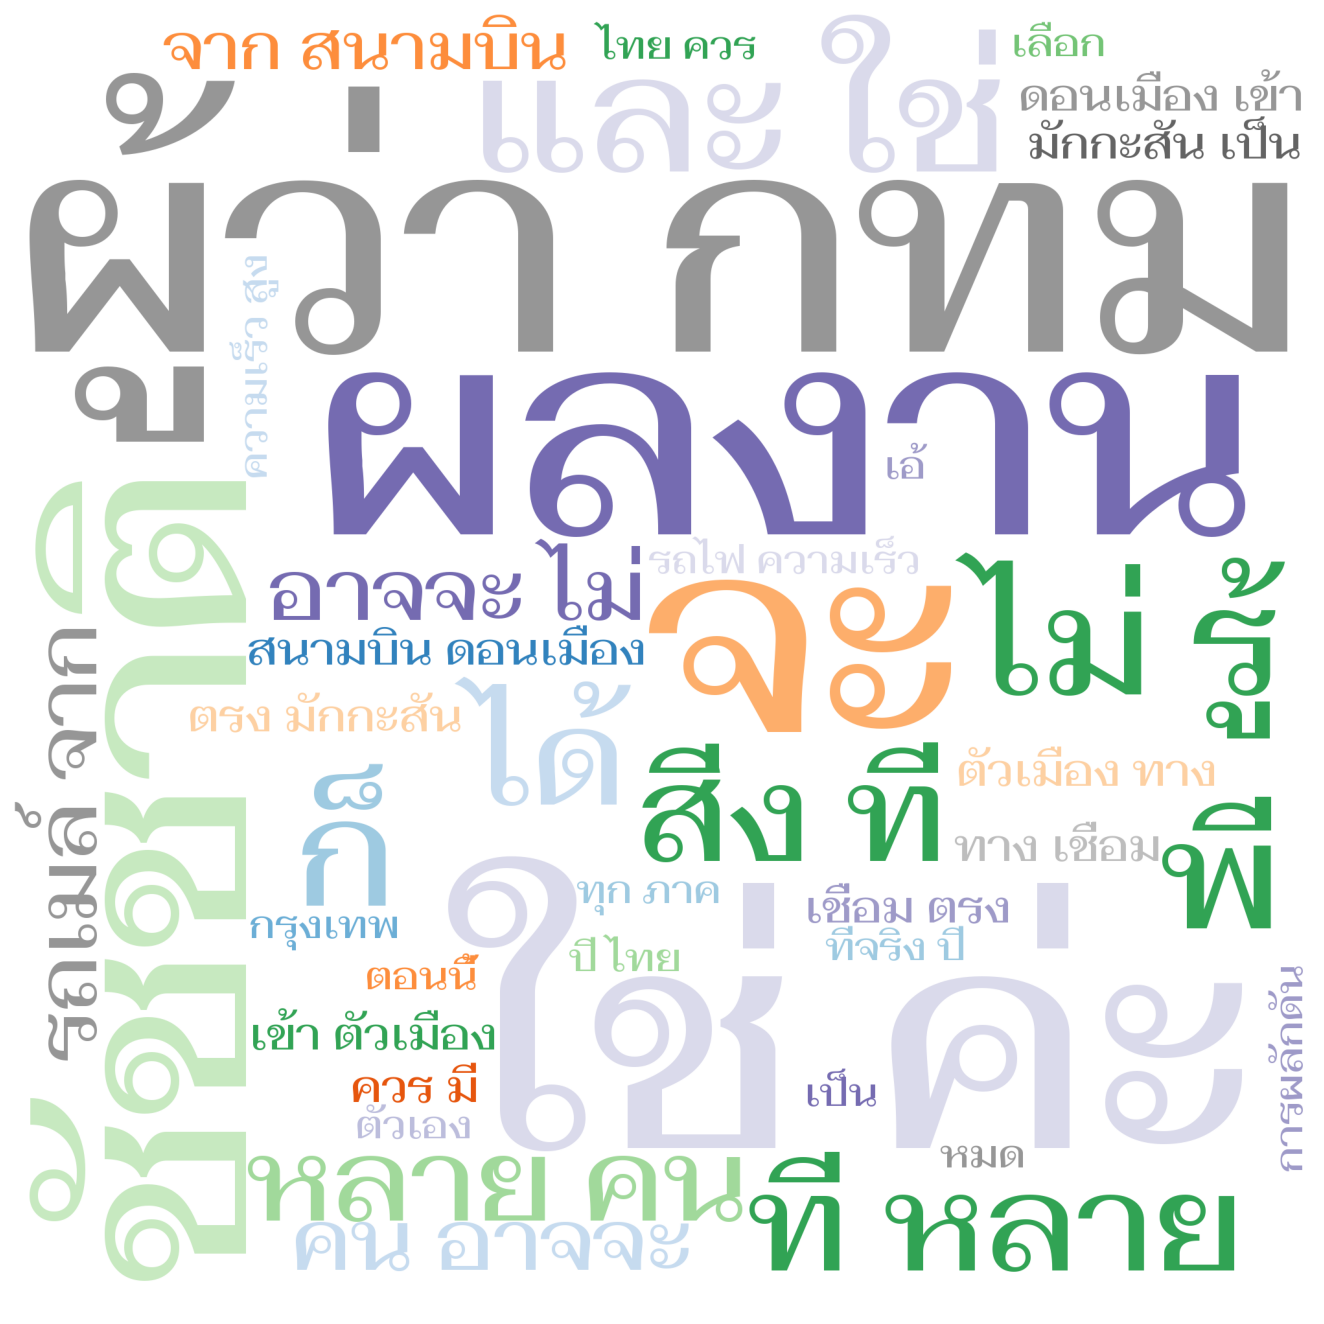

In [33]:
wordcloud = WordCloud(
#     font_path='c:/windows/fonts/browalia.ttc',
#     font_path='C:/Users/thirawat/Desktop/word_cloud_thai/font_path/Fahkwang-Medium.ttf',
#     font_path='font_path/Kanit-Black.ttf',
    font_path='font_path/Fahkwang-Medium.ttf',
    regexp='[ก-๙]+',

    stopwords=stopwords,
    width=2000, height=2000,

    prefer_horizontal=.9,
    max_words=40, 

#     colormap='viridis', # default matplotlib colormap
    colormap='tab20c',
#     colormap='plasma',
    background_color = 'white').generate(all_words)
plt.figure(figsize = (10, 9))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
# plt.show()